예측값: [ 7.66065005  8.03179996 10.78970001  9.69109982 16.74025036]
실제값: [ 6.11000013  7.46999979  9.93999958  9.27999973 15.14000034]


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

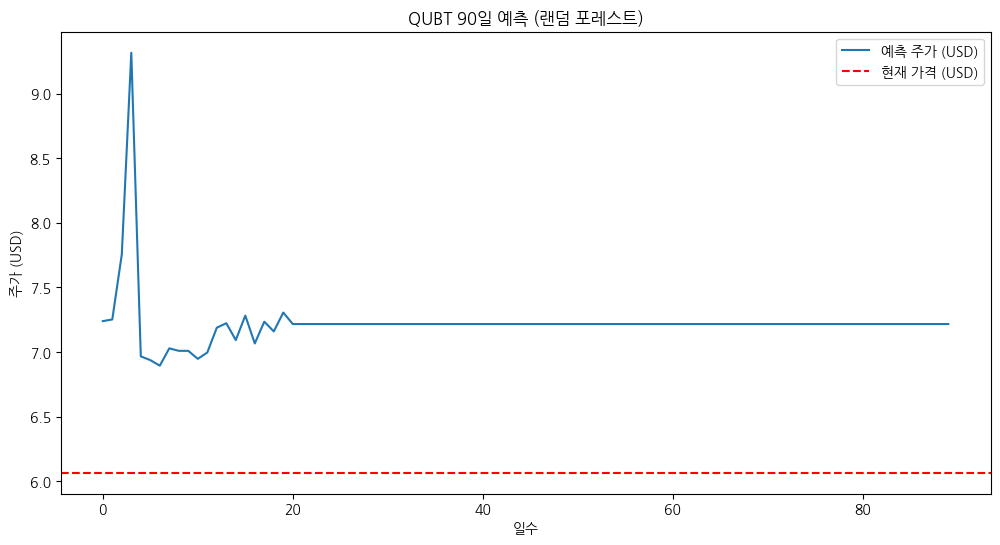

In [9]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 주가 데이터 가져오기 (달러 기준)
stock = yf.Ticker("QUBT")
data = stock.history(start="2024-11-01", end="2025-03-03")

# 특징(feature) 생성: 종가, 5일/20일 이동평균
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
data = data.dropna()

# 특징과 타겟 설정
features = ['Close', 'MA5', 'MA20']
X = data[features]
y = data['Close'].shift(-1).dropna()  # 다음 날 종가
X = X[:-1]  # 타겟과 동일한 길이로 조정

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 테스트 데이터 예측
predictions = model.predict(X_test)
print("예측값:", predictions[:5])
print("실제값:", y_test[:5].values)

# 미래 90일 예측 (동적 업데이트)
last_row = data[features].iloc[-1].values.reshape(1, -1)  # 2차원 배열로 초기화 (1, 3)
future_predictions = []
for _ in range(90):
    # 현재 데이터로 예측 (2차원 배열 유지)
    next_price = model.predict(last_row)[0]
    future_predictions.append(next_price)
    # 이동평균 업데이트
    new_row = np.array([[next_price, next_price, next_price]])  # (1, 3)
    last_row = (last_row * 4 + new_row) / 5  # 간단한 이동평균 반영 (5일 기준 가중치)

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(future_predictions, label="예측 주가 (USD)")
plt.axhline(y=data['Close'].iloc[-1], color='r', linestyle='--', label="현재 가격 (USD)")
plt.title("QUBT 90일 예측 (랜덤 포레스트)")
plt.xlabel("일수")
plt.ylabel("주가 (USD)")
plt.legend()
plt.show()

#### 결론 : 랜덤포레스트의 한계성
- 20일 이후의 추가적인 변동성을 예측하지 못하여 20일 이후 수평적인 그래프가 발생(추가하더라도 랜덤포레스트의 한계점 때문에 그래프가 비현실적으로 바뀜)
- 랜덤 포레스트는 단기 예측에는 적합하지만, 장기 예측(90일)에서는 트렌드나 계절성을 반영하기 어려움 노이즈를 추가했더라도, 근본적으로 모델이 장기 패턴을 학습하지 못하면 유의미한 예측이 어렵다.